In [3]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding_script import angle_encoding
from haar_noising_script import apply_haar_scrambling

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG1_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_28804\2308068479.py:18: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


Epoch [1/50], Loss: 1.0024, Val Loss: 0.7925, FID: 200.9388
Epoch [2/50], Loss: 0.7951, Val Loss: 0.5932, FID: 149.3066
Epoch [3/50], Loss: 0.5898, Val Loss: 0.4013, FID: 99.4811
Epoch [4/50], Loss: 0.4029, Val Loss: 0.2308, FID: 55.0327
Epoch [5/50], Loss: 0.2369, Val Loss: 0.1025, FID: 21.2787
Epoch [6/50], Loss: 0.1002, Val Loss: 0.0424, FID: 4.9112
Epoch [7/50], Loss: 0.0425, Val Loss: 0.0669, FID: 10.2501
Epoch [8/50], Loss: 0.0731, Val Loss: 0.1336, FID: 26.7059
Epoch [9/50], Loss: 0.1394, Val Loss: 0.1716, FID: 36.2496
Epoch [10/50], Loss: 0.1613, Val Loss: 0.1658, FID: 34.9099
Epoch [11/50], Loss: 0.1600, Val Loss: 0.1309, FID: 26.2979
Epoch [12/50], Loss: 0.1188, Val Loss: 0.0897, FID: 16.1762
Epoch [13/50], Loss: 0.0693, Val Loss: 0.0580, FID: 8.4694
Epoch [14/50], Loss: 0.0497, Val Loss: 0.0395, FID: 4.1560
Epoch [15/50], Loss: 0.0398, Val Loss: 0.0335, FID: 2.9545
Epoch [16/50], Loss: 0.0354, Val Loss: 0.0357, FID: 3.7949
Epoch [17/50], Loss: 0.0417, Val Loss: 0.0416, FID: 

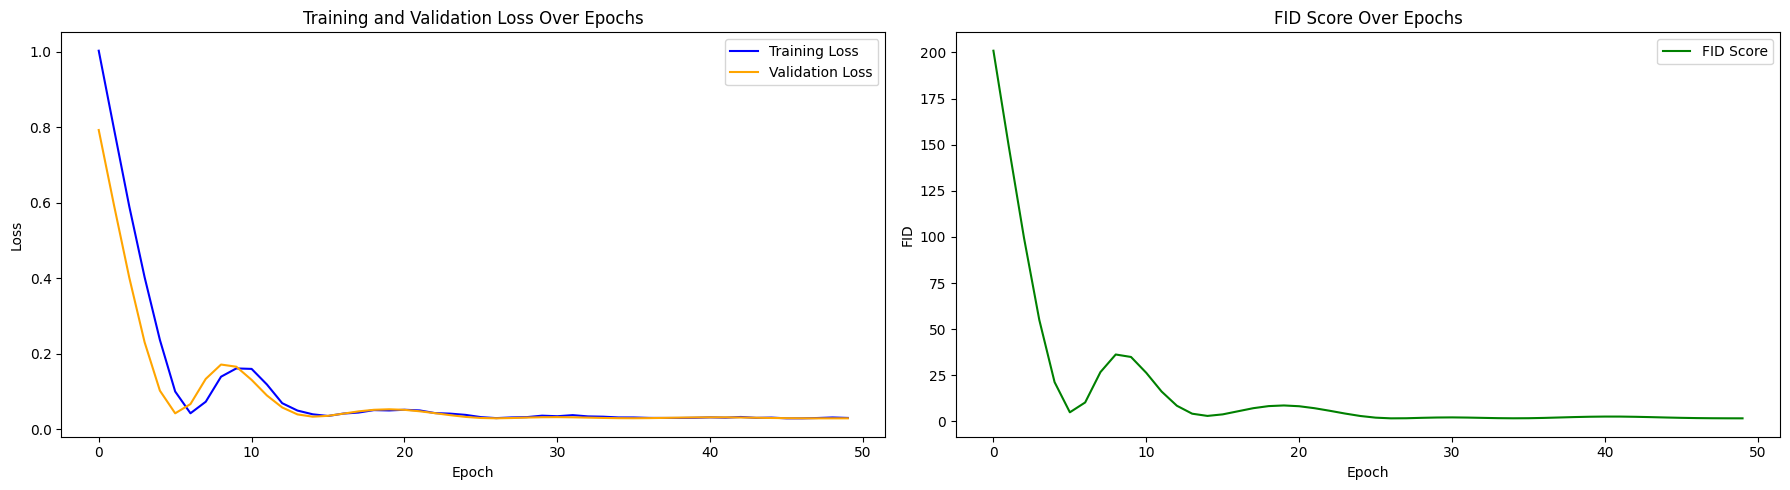

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import pennylane as qml

# Load and prepare your data
filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG1_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100
encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # Flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

n_layers = 6
input_dim = 8 * 8 * 4  # Assuming input is flattened
hidden_dim = 128
output_dim = input_dim  # To match the dimensions after the final layer

# Initialize the quantum diffusion model
model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

# Plotting the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


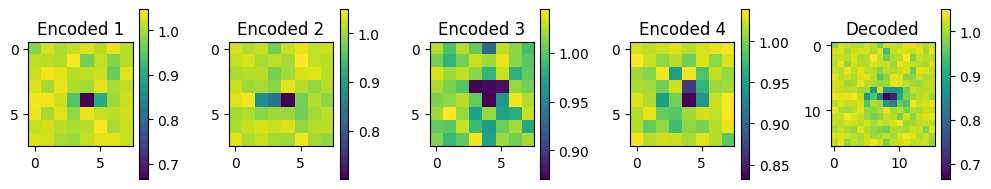

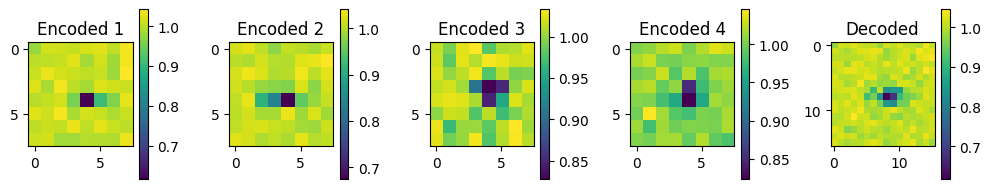

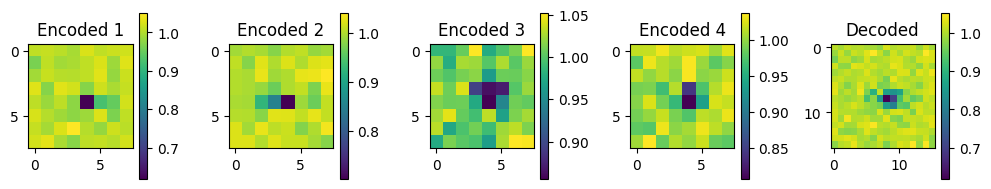

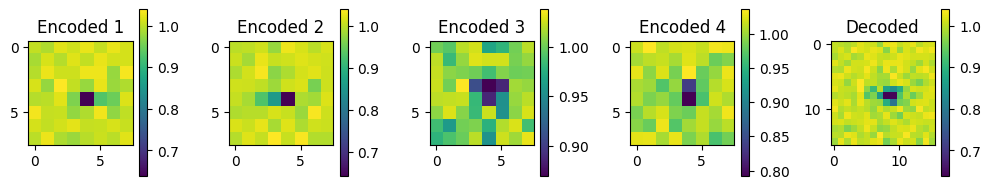

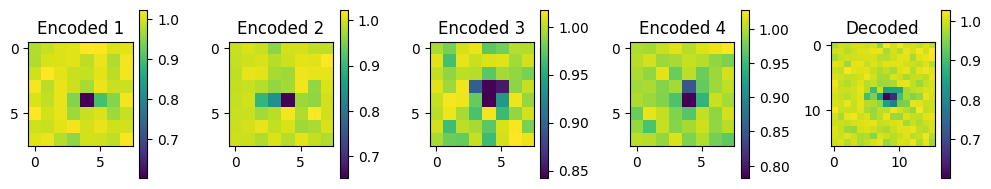

In [6]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            # decoded_images = flip(decode(generated_data))
            decoded_images = decode(generated_data)
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)
